# Comparing results JUSUF sweep with 6 values/parameter but with different coeff_inh


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

from JUSUFlike.Project.Codes.processing_results_sweep6 import *
import tvb_model_reference.src.nuu_tools_simulation_human as tools

/home/master/anaconda3/envs/tvbadexgraph/lib/python3.10/site-packages/tvb/datatypes/surfaces.py:63: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
def make_movie_sweep(metrics, fixed_params, params_sweep_im, param_sweep_time, title_movie, movies_folder, 
                     batches_folder, steps, imshow_batches):
    # This dictionary is in processing_results.py, can be deleted
    ranges_params = {'a': (0, 0.5), 'b_e': (0, 120), 'E_L_e': (-80, -60), 'E_L_i': (-80, -60), 'T': (5, 40)}
    movie_folder = movies_folder + title_movie + '/'
    try:
        os.listdir(movie_folder)
    except:
        os.mkdir(movie_folder)


    values_time = np.linspace(ranges_params[param_sweep_time][0], ranges_params[param_sweep_time][1], steps)

    for frame, value in enumerate(values_time):
        fixed_params[param_sweep_time] = value
        fig = plot_multiple_metrics(metrics, batches_folder, params_sweep_im, fixed_params, steps, imshow_ranges)
        fig.savefig(movie_folder + f'frame{frame}.png')
        plt.close()


    images = []
    for step in range(steps):
        filename = movie_folder + f'frame{step}.png'
        images.append(imageio.imread(filename))
    imageio.mimsave(movie_folder + title_movie + '.gif', images, duration=0.5)

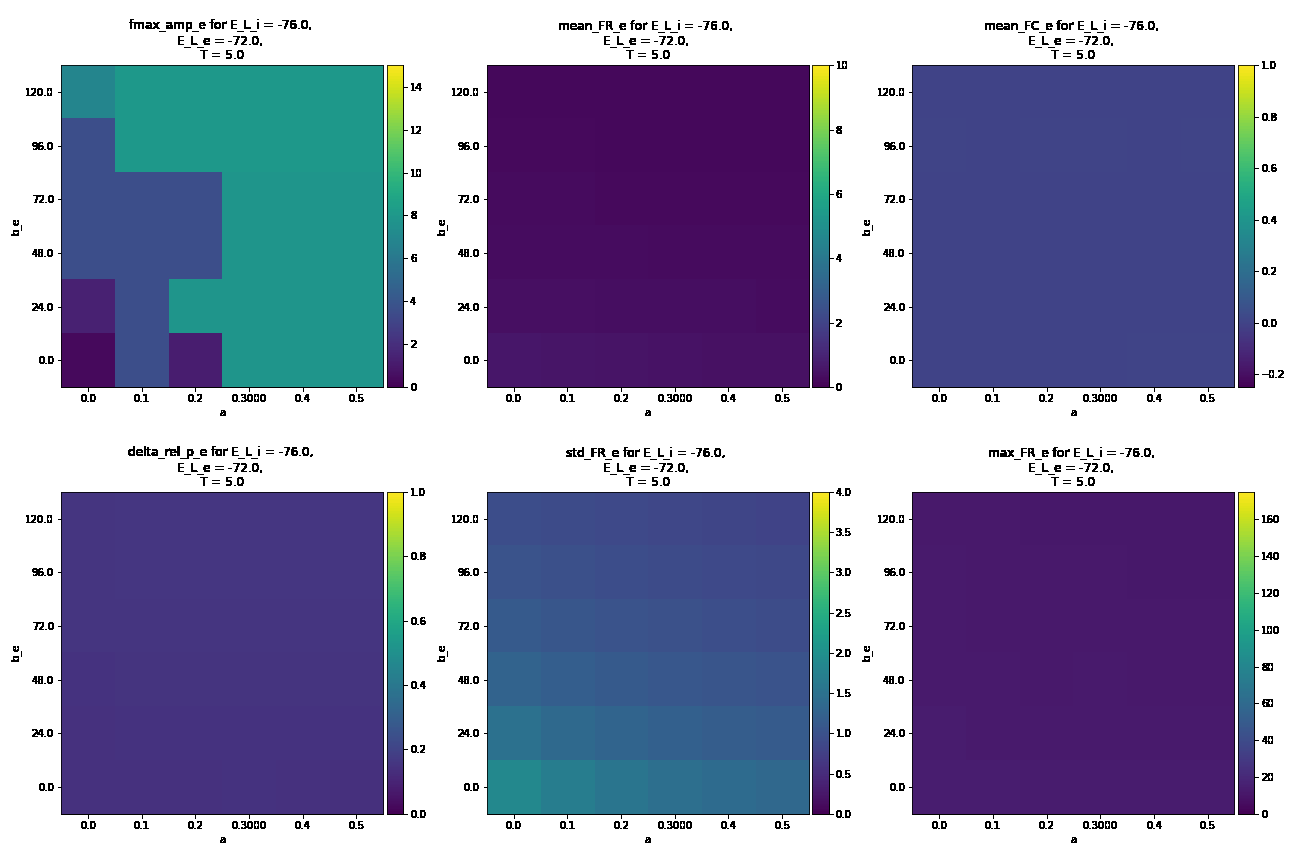

In [134]:
# I WILL WRITE A FUNCTION THAT OBTAINS THE GIF AND THEN I WILL HAVE TO STORE IT IN THE PROCESSING RESULTS SCRIPT
import imageio
from IPython.display import Image

coeff_sweep = 'coeff_inh_1.6'

# These will be the inputs to the file
fixed_params = {'E_L_i': -76, 'E_L_e': -72}
params_sweep_im = ('a', 'b_e')
param_sweep_time = 'T'

title_movie = 'T_evolution_of_a_b_haha'

movies_folder = '/home/master/Desktop/tests_hpc/figures/sweep_step6/movie/'
batches_folder = './batches_sweep6/' + coeff_sweep + '/'

steps = 6
metrics = ['fmax_amp_e', 'mean_FR_e', 'mean_FC_e', 
           'delta_rel_p_e', 'std_FR_e', 'max_FR_e']
imshow_ranges = [(0, 15), (0, 10), (-0.25, 1), (0, 1), (0, 4), (0, 175)]

make_movie_sweep(metrics, fixed_params, params_sweep_im, param_sweep_time, title_movie, movies_folder, 
                     batches_folder, steps, imshow_ranges)

Image(filename=movies_folder + title_movie + '/' + title_movie + '.gif')

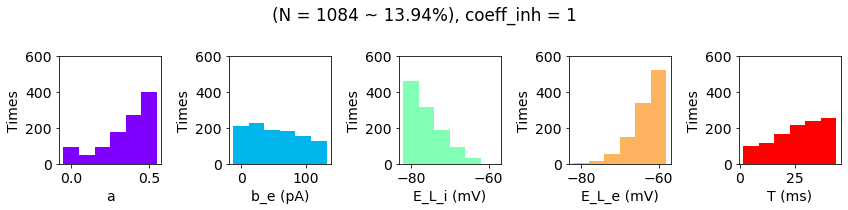

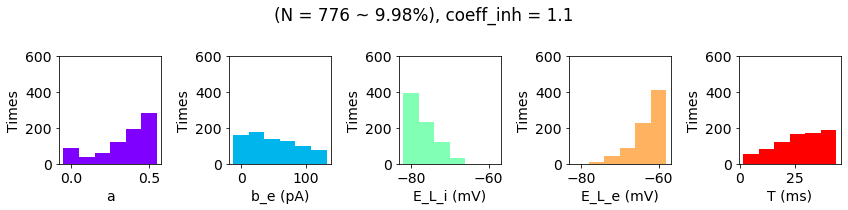

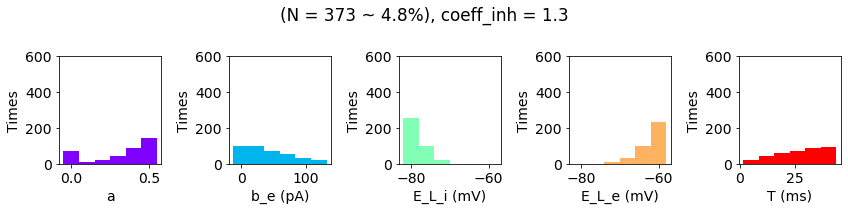

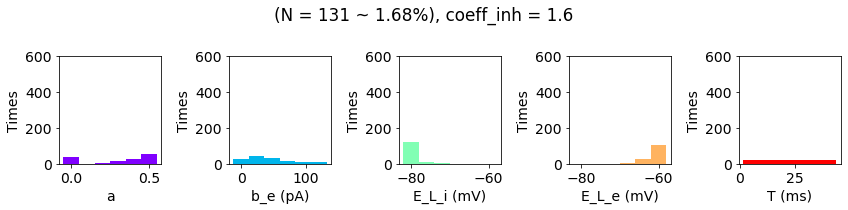

In [13]:
coeff_sweep_vals = [1, 1.1, 1.3, 1.6]

for value_inh in coeff_sweep_vals:

    coeff_sweep = 'coeff_inh_' + str(value_inh)

    figures_folder = '/home/master/Desktop/tests_hpc/figures/sweep_step6/' + coeff_sweep + '/'
    batches_folder = './batches_sweep6/' + coeff_sweep + '/'

    max_FRs_e = load_metric_sweeps('max_FR_e', batches_folder, steps=6)

    broken_point = np.amax(max_FRs_e)
    max_frs = np.arange(np.ceil(broken_point) + 1)
    n_combs_over = np.zeros_like(max_frs)
    n_combs_over_e = np.zeros_like(max_frs)


    # Let us count the parameters that have the highest values
    n_params = 5
    steps_per_par = 6
    label_params = ['a', 'b_e (pA)', 'E_L_i (mV)', 'E_L_e (mV)', 'T (ms)']
    all_bins = []
    all_counts = []
    all_centers = []
    for id_param in range(n_params):
        bins = np.zeros(steps_per_par + 1)  # 6 steps per parameter
        vals = np.sort(np.unique(max_FRs_e[:, id_param]))
        step = vals[1] - vals[0]
        bins = np.linspace(vals[0], vals[-1] + step, steps_per_par + 1) - step / 2
        centers = np.linspace(vals[0], vals[-1], steps_per_par)
        all_bins.append(bins)
        all_counts.append(np.zeros(steps_per_par))
        all_centers.append(centers)

    for idx, (param_centers, param_counts) in enumerate(zip(all_centers, all_counts)):
        for ii, value in enumerate(param_centers):
            param_counts[ii] = np.sum(np.logical_and(max_FRs_e[:, -1] > broken_point-2, 
                                                     max_FRs_e[:, idx] == value))
    
    fig, axes = plt.subplots(1, n_params, figsize=(12, 3))
    color = iter(plt.cm.rainbow(np.linspace(0, 1, n_params)))

    limit_val = 190
    idxes = max_FRs_e[:, -1] > limit_val
    number_of_bp = np.sum(idxes)
    for ii, ax in enumerate(axes):
        c = next(color)
        ax.hist(max_FRs_e[idxes, ii], bins=all_bins[ii], align='mid', color=c)
        ax.set(ylim=(0, 600), xlabel=label_params[ii], ylabel='Times')
        
    fig.suptitle(f'(N = {number_of_bp} ~ {round(100 * number_of_bp/steps_per_par**5, 2)}%), coeff_inh = {value_inh}')
    plt.tight_layout()
    fig.savefig(figures_folder + 'distribution_bps.png')
    plt.show()

# Comments

- For coeff_inh = 1, E_L_i = -68, E_L_e = -80, T = 33 it seems like there is a point that has not been simulated, or that there is a problem with. I don't understand why because the length is 7776, maybe there has been a problem and two processes have simulated the same combination? I could try to find the point that has been incorrectly simulated, run it and attach it to the batches (if I find the incorrect one.)

- For coeff_inh = 1.1, E_L_i = -60, E_L_e = -64, T = 19 there has been another fail.